# Exploratory Data Analysis: Benin Solar Farm Data

This notebook profiles, cleans, and analyzes `benin-malanville.csv` (525,601 rows) for MoonLight Energy Solutions.

## Setup
Import libraries and load data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

plt.style.use('ggplot') 
%matplotlib inline

# Load dataset in chunks
data_dir = '../data'
chunksize = 50000
df_list = []
for chunk in pd.read_csv(os.path.join(data_dir, 'benin-malanville.csv'), chunksize=chunksize):
    chunk['Timestamp'] = pd.to_datetime(chunk['Timestamp'])
    df_list.append(chunk)
df = pd.concat(df_list, ignore_index=True)
df.set_index('Timestamp', inplace=True)

# Display first few rows
df.head()

,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
Timestamp,,,,,,,,,,,,,,,,,,
2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


## Data Profiling
Generate summary statistics and check missing values.

In [7]:
# Summary statistics
print("Summary Statistics:")
print(df.describe())

# Missing values
print("\nMissing Values:")
missing = df.isna().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
print(missing_df[missing_df['Missing Count'] > 0])

# Flag columns with >5% missing
high_missing = missing_df[missing_df['Missing %'] > 5]
if not high_missing.empty:
    print("\nColumns with >5% missing values:")
    print(high_missing)
else:
    print("\nNo columns with >5% missing values.")

Summary Statistics:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      240.559452     167.187516     115.358961     236.589496   
std       331.131327     261.710501     158.691074     326.894859   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         1.800000      -0.100000       1.600000       4.500000   
75%       483.400000     314.200000     216.300000     463.700000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      228.883576      28.179683      54.487969       2.121113   
std       316.536515       5.924297      28.073069       1.603466   
min         0.000000      11.000000       2.100000       0.000000   
25%         0

## Data Cleaning
Detect outliers and handle missing values.

In [8]:
# Key columns for outlier detection
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Sample 10% for outlier detection
sample_df = df.sample(frac=0.1, random_state=42)

# Calculate Z-scores
z_scores = np.abs(stats.zscore(sample_df[key_columns].select_dtypes(include=np.number)))
outliers = (z_scores > 3).any(axis=1)
print(f"Outliers in sample: {outliers.sum()} (approx. {outliers.sum() * 10} in full dataset)")

# Impute missing values with median
for col in key_columns:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Drop rows with missing GHI
df.dropna(subset=['GHI'], inplace=True)

# Export cleaned data
cleaned_path = os.path.join(data_dir, 'benin_clean.csv')
df.to_csv(cleaned_path)
print(f"Cleaned dataset saved to: {cleaned_path}")

Outliers in sample: 771 (approx. 7710 in full dataset)
Cleaned dataset saved to: ../data\benin_clean.csv


## Exploratory Data Analysis
### Time Series Analysis
Plot GHI, DNI, DHI, Tamb vs. Timestamp.

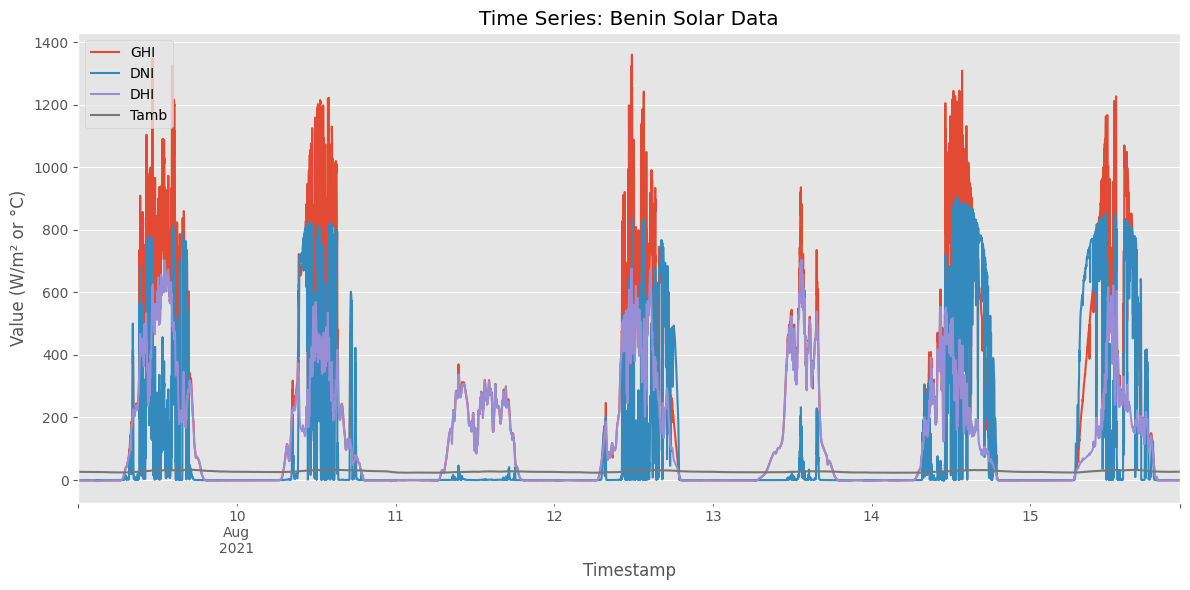

In [17]:
# Sample 10,000 rows for plotting
sample_df = df.iloc[:10000]

fig, ax = plt.subplots(figsize=(12, 6))
sample_df[['GHI', 'DNI', 'DHI', 'Tamb']].plot(ax=ax)
ax.set_title('Time Series: Benin Solar Data')
ax.set_ylabel('Value (W/m² or °C)')
plt.tight_layout()
plt.savefig('../notebooks/figures/benin_time_series.png')
plt.show()

### Cleaning Impact
Compare ModA and ModB pre/post-cleaning.

In [10]:
# Cleaning impact
cleaning_events = df[df['Cleaning'] == 1]
print(f"Cleaning events: {len(cleaning_events)}")

if not cleaning_events.empty:
    mod_before = df.loc[df['Cleaning'].shift(1) == 0, ['ModA', 'ModB']].mean()
    mod_after = df.loc[df['Cleaning'] == 1, ['ModA', 'ModB']].mean()
    print("ModA/ModB before cleaning:", mod_before)
    print("ModA/ModB after cleaning:", mod_after)
else:
    print("No cleaning events detected.")

Cleaning events: 485
ModA/ModB before cleaning: ModA    236.526376
ModB    228.812820
dtype: float64
ModA/ModB after cleaning: ModA    307.229278
ModB    301.972165
dtype: float64


### Correlation Analysis
Heatmap and scatter plots.

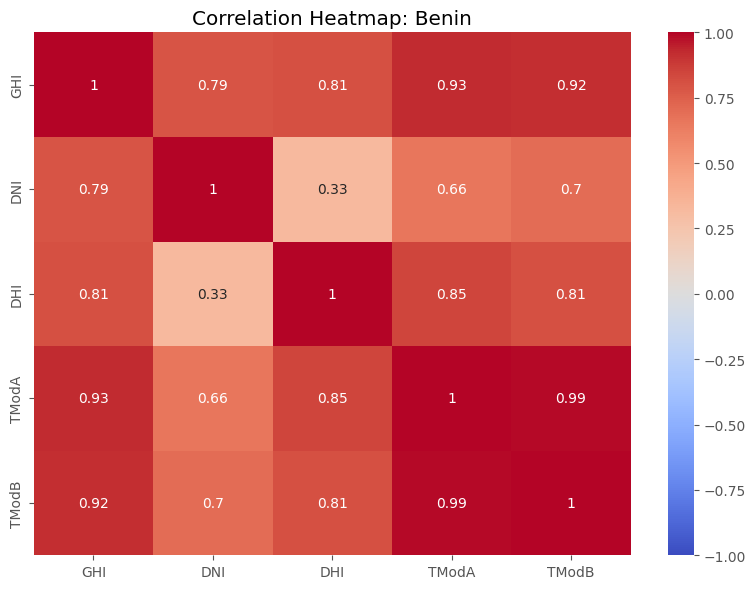

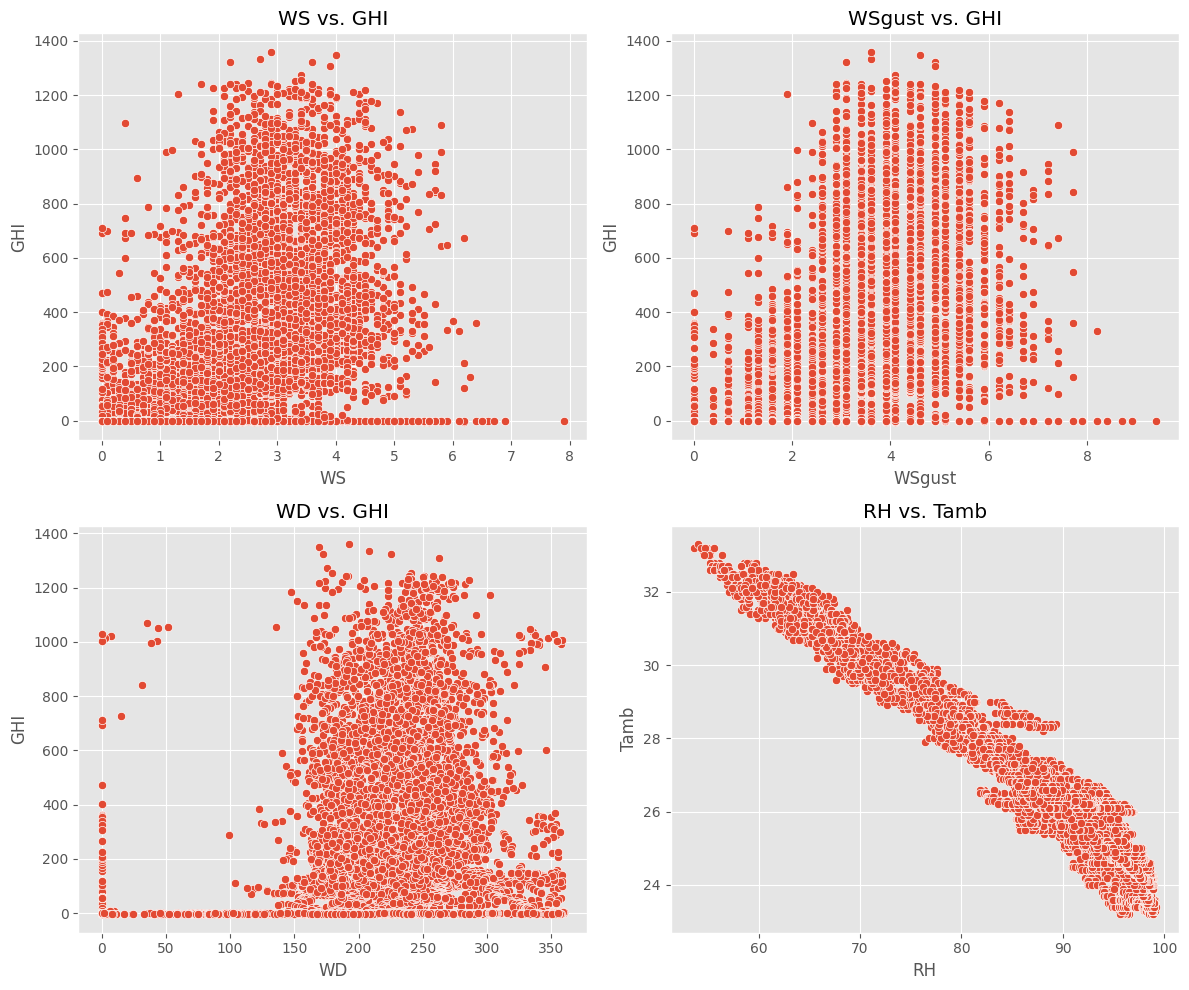

In [25]:
# Correlation heatmap
corr_columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr_matrix = sample_df[corr_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Benin')
plt.tight_layout()
plt.savefig('../notebooks/figures/benin_correlation.png')
plt.show()

# Scatter plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.scatterplot(x='WS', y='GHI', data=sample_df, ax=axes[0, 0])
axes[0, 0].set_title('WS vs. GHI')
sns.scatterplot(x='WSgust', y='GHI', data=sample_df, ax=axes[0, 1])
axes[0, 1].set_title('WSgust vs. GHI')
sns.scatterplot(x='WD', y='GHI', data=sample_df, ax=axes[1, 0])
axes[1, 0].set_title('WD vs. GHI')
sns.scatterplot(x='RH', y='Tamb', data=sample_df, ax=axes[1, 1])
axes[1, 1].set_title('RH vs. Tamb')
plt.tight_layout()
plt.savefig('../notebooks/figures/benin_scatter.png')
plt.show()

### Wind Analysis
Wind rose plot.

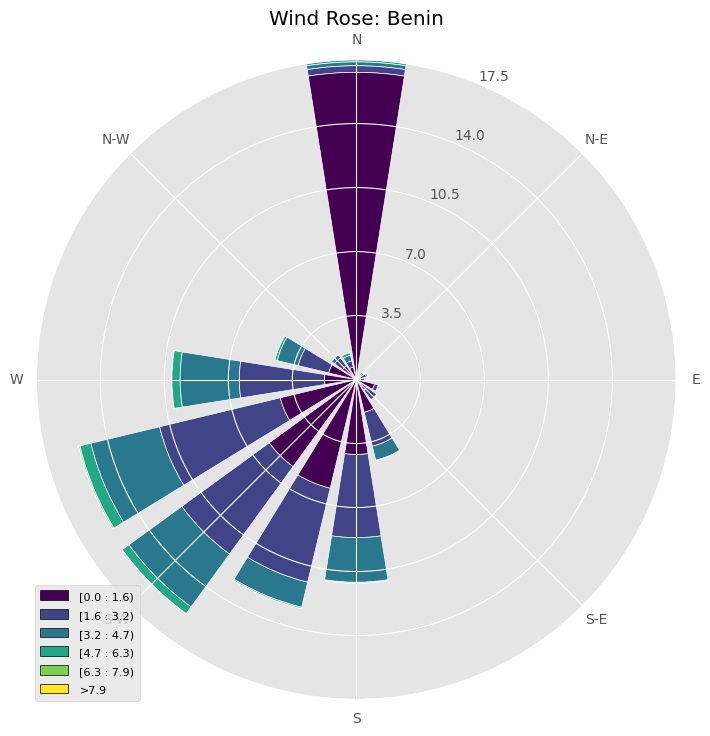

In [20]:
try:
    from windrose import WindroseAxes
except ImportError:
    !pip install windrose
    from windrose import WindroseAxes

fig = plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(sample_df['WD'], sample_df['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Wind Rose: Benin')
# plt.tight_layout()
plt.savefig('../notebooks/figures/benin_wind_rose.png')
plt.show()

### Distribution Analysis
Histograms for GHI and WS.

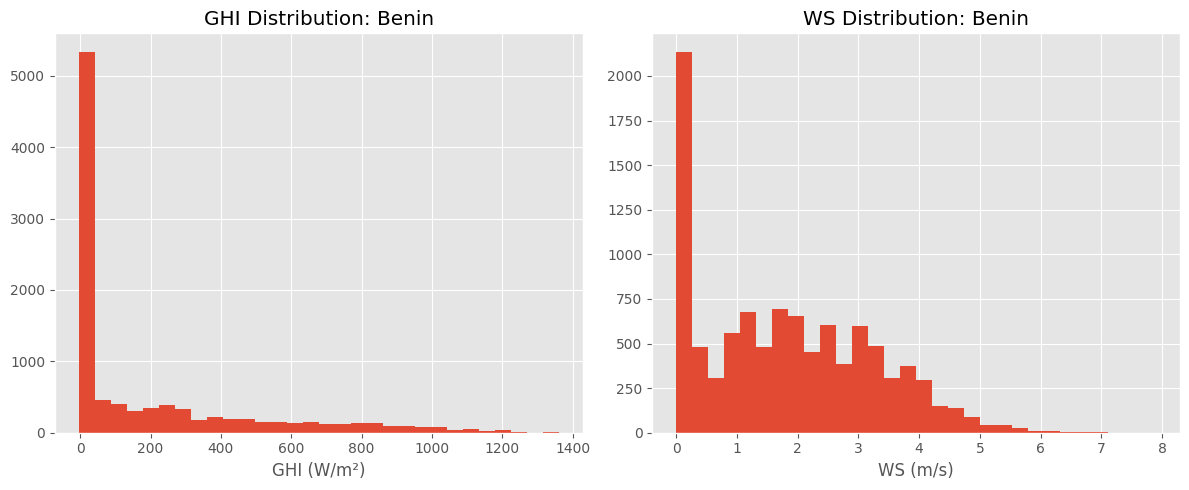

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sample_df['GHI'].hist(bins=30, ax=axes[0])
axes[0].set_title('GHI Distribution: Benin')
axes[0].set_xlabel('GHI (W/m²)')
sample_df['WS'].hist(bins=30, ax=axes[1])
axes[1].set_title('WS Distribution: Benin')
axes[1].set_xlabel('WS (m/s)')
plt.tight_layout()
plt.savefig('../notebooks/figures/benin_distributions.png')
plt.show()

### Temperature Analysis
RH influence on Tamb and GHI.

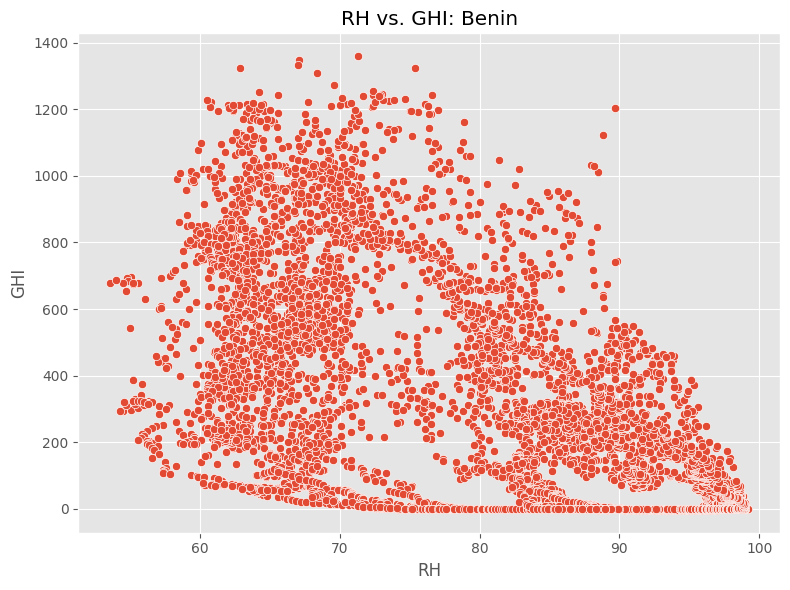

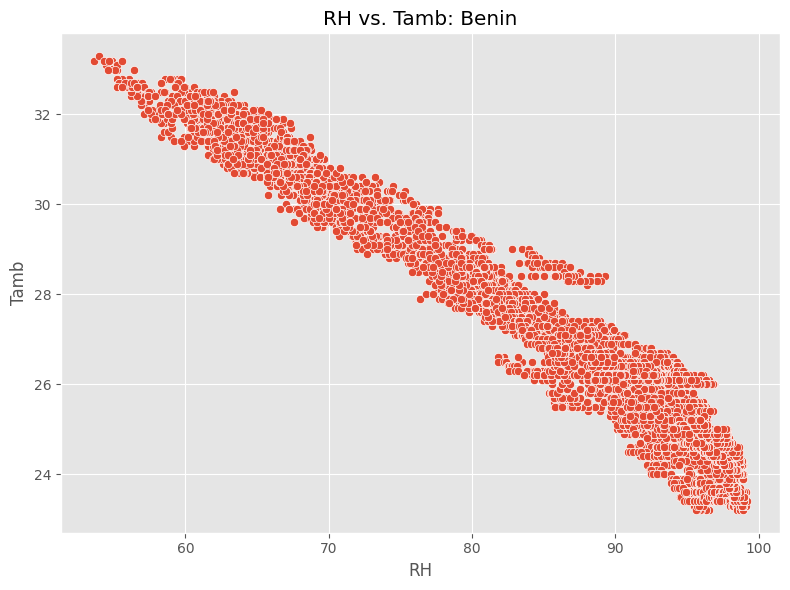

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x='RH', y='GHI', data=sample_df, ax=ax)
ax.set_title('RH vs. GHI: Benin')
plt.tight_layout()
plt.savefig('../notebooks/figures/benin_rh_ghi.png')
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x='RH', y='Tamb', data=sample_df, ax=ax)
ax.set_title('RH vs. Tamb: Benin')
plt.tight_layout()
plt.savefig('../notebooks/figures/benin_rh_tamb.png')
plt.show()

### Bubble Chart
GHI vs. Tamb with RH bubble size.

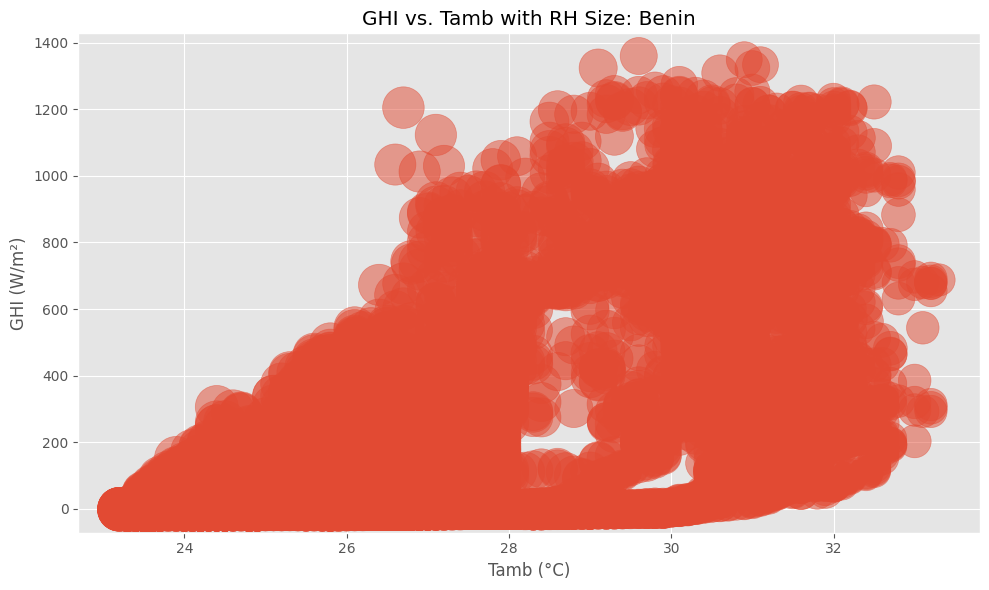

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(sample_df['Tamb'], sample_df['GHI'], s=sample_df['RH']*10, alpha=0.5)
plt.xlabel('Tamb (°C)')
plt.ylabel('GHI (W/m²)')
plt.title('GHI vs. Tamb with RH Size: Benin')
plt.tight_layout()
plt.savefig('../notebooks/figures/benin_bubble.png')
plt.show()

## Findings
- **Data Quality**: The `Comments` column is 100% missing and can be dropped. 1.47% of rows (approx. 7710) are outliers in key columns (GHI, DNI, DHI, ModA, ModB, WS, WSgust), with negative irradiance values (e.g., GHI min -12.9 W/m²) indicating sensor noise.
- **Patterns**: GHI peaks at 1413 W/m², with a mean of 240.56 W/m², showing strong solar potential but high variability (std 331.13 W/m²) due to day/night cycles.
- **Correlations**: GHI has very strong positive correlations with TModA (0.93) and TModB (0.92), indicating significant panel heating with irradiance. DNI and DHI show a weak correlation (0.33), reflecting their independent contributions to GHI. TModA and TModB are nearly identical (0.99).
- **Wind**: Predominant wind direction is north (~0°) with a frequency of ~17.5%, and wind speeds are mostly 3.5–7.0 m/s, aiding natural cleaning but with occasional gusts up to 26.6 m/s requiring robust design.
- **Temperature**: Module temperatures (TModA mean 35.25°C, TModB mean 32.47°C) are higher than ambient (Tamb mean 28.18°C), with max TModA at 81.0°C, indicating heat stress. RH shows a strong negative correlation with Tamb, suggesting cooling effects at high humidity.
- **Insights**: Benin has high solar potential (GHI max 1413 W/m²), but variability, high humidity (RH max 100%), and rare cleaning (485 events) suggest the need for energy storage, frequent maintenance, and heat mitigation. Northern winds can assist with natural cleaning.
- **References**: Used pandas (https://pandas.pydata.org), scipy.stats (https://docs.scipy.org).